## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import config_notebook as c
from torch.optim import Adam
from torchvision.utils import save_image
import datetime

## Set global parameters

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
# Initialize hyperparameters
num_epochs = c.EPOCHS
adversarial_loss = torch.nn.BCELoss()
reconstruction_loss = torch.nn.L1Loss()
adam_lr = c.ADAM_LR
adam_beta1 = c.ADAM_BETA1
real_label = 1.0
fake_label = 0.0

## Initialize models

In [5]:
from image_colorization.src.discriminator import Discriminator
from image_colorization.src.generator import Generator

# Initialize models
generator = Generator()
discriminator = Discriminator()

## Load data

In [6]:
from dataloader_anaglyph import make_dataloaders

# Make dataloaders
train_dl = make_dataloaders(path_anaglyph=c.TRAIN_ANAGLYPH_FILE, path_left=c.TRAIN_LEFT_FILE, path_right=c.TRAIN_RIGHT_FILE, image_size=c.IMAGE_SIZE)
val_dl = make_dataloaders(path_anaglyph=c.VALIDATION_ANAGLYPH_FILE, path_left=c.VALIDATION_LEFT_FILE, path_right=c.VALIDATION_RIGHT_FILE, image_size=c.IMAGE_SIZE)
print(len(train_dl), len(val_dl))

28 7


In [7]:
first_item = next(iter(train_dl))
print(first_item['a'].shape)
print(first_item['l'].shape)
print(first_item['r'].shape)

torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])


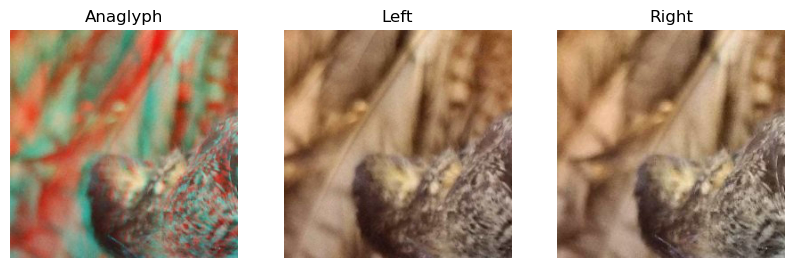

In [8]:
from itertools import islice
import torchvision.transforms as T

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

transform = T.ToPILImage()

# Plot the anaglyph image
axes[0].imshow(transform(first_item['a'][0]))  # Convert tensor to image
axes[0].set_title("Anaglyph")
axes[0].axis("off")

# Plot the left image
axes[1].imshow(transform(first_item['l'][0]))  # Convert tensor to image
axes[1].set_title("Left")
axes[1].axis("off")

# Plot the right image
axes[2].imshow(transform(first_item['r'][0]))  # Convert tensor to image
axes[2].set_title("Right")
axes[2].axis("off")

plt.show()

## Training function

In [9]:
def validate_model(generator, validation_dl, device, results_save_path, epoch):
    """
    Validate the generator with a few images and save the outputs.
    """
    generator.eval()  # Set to evaluation mode
    with torch.no_grad():
        for i, batch in enumerate(validation_dl):
            if i >= c.NUM_VALIDATION_IMG:
                break

            img_anaglyph = batch['a'].to(device)  # Preprocessed anaglyph image
            fake_left, fake_right = generator(img_anaglyph)

            # Generate timestamp
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

            # Save the results
            save_image(fake_left, f"{results_save_path}/epoch_{epoch+1}_img_{i+1}_{timestamp}_left.png")
            save_image(fake_right, f"{results_save_path}/epoch_{epoch+1}_img_{i+1}_{timestamp}_right.png")
            print(f"Saved validation results for image {i+1} of epoch {epoch+1} at {timestamp}")

            # Plot the results
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(img_anaglyph[0].cpu().permute(1, 2, 0) * 0.5 + 0.5)
            axes[0].set_title("Anaglyph")
            axes[0].axis("off")

            axes[1].imshow(fake_left[0].cpu().permute(1, 2, 0) * 0.5 + 0.5)
            axes[1].set_title("Generated Left")
            axes[1].axis("off")

            axes[2].imshow(fake_right[0].cpu().permute(1, 2, 0) * 0.5 + 0.5)
            axes[2].set_title("Generated Right")
            axes[2].axis("off")

            plt.show()

    generator.train()  # Return to training mode

In [12]:
def train_gan(generator, discriminator, dataloader, num_epochs, device, test_run=False):

    # Move models to device
    generator.to(device)
    discriminator.to(device)

    # Optimizers
    optimizer_G = Adam(generator.parameters(), lr=c.ADAM_LR, betas=(c.ADAM_BETA1, 0.999))
    optimizer_D = Adam(discriminator.parameters(), lr=c.ADAM_LR, betas=(c.ADAM_BETA1, 0.999))

    # Training loop
    for epoch in range(num_epochs):
        g_loss_epoch = 0.0  # Accumulate generator loss for the epoch
        d_loss_epoch = 0.0  # Accumulate discriminator loss for the epoch

        for i, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            # Extract images from batch and preprocess
            img_anaglyph = batch['a'].to(device)  # Preprocess anaglyph image
            img_left =batch['l'].to(device)      # Preprocess left stereo image
            img_right = batch['r'].to(device)     # Preprocess right stereo image

            # ======== Train Discriminator ========
            optimizer_D.zero_grad()

            # Train with real stereo images
            output_real = discriminator(img_left, img_right).view(-1)
            label_real = torch.full_like(output_real, real_label, device=device)
            loss_real = adversarial_loss(output_real, label_real)

            # Train with fake stereo images
            fake_left, fake_right = generator(img_anaglyph)
            output_fake = discriminator(fake_left.detach(), fake_right.detach()).view(-1)
            label_fake = torch.full_like(output_fake, fake_label, device=device)
            loss_fake = adversarial_loss(output_fake, label_fake)

            # Combine losses
            loss_D = loss_real + loss_fake
            loss_D.backward()
            optimizer_D.step()

            # ======== Train Generator ========
            optimizer_G.zero_grad()

            # Generator tries to fool the discriminator
            output_fake = discriminator(fake_left, fake_right).view(-1)
            label_fake_for_gen = torch.full_like(output_fake, real_label, device=device)  # Trick discriminator
            loss_G_adv = adversarial_loss(output_fake, label_fake_for_gen)

            # Compute reconstruction loss (L1 loss between generated and real left/right images)
            loss_G_recon = reconstruction_loss(fake_left, img_left) + reconstruction_loss(fake_right, img_right)

            # Total generator loss = adversarial loss + reconstruction loss
            loss_G = loss_G_adv + loss_G_recon

            loss_G.backward()
            optimizer_G.step()

            # Update epoch loss
            d_loss_epoch += loss_D.item()
            g_loss_epoch += loss_G.item()

            i += 1

        # Log epoch losses
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Discriminator Loss: {d_loss_epoch/len(dataloader):.4f}, "
              f"Generator Loss: {g_loss_epoch/len(dataloader):.4f}")

        # Generate timestamp
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

        # Save model checkpoints
        torch.save(generator.state_dict(), os.path.join(c.MODEL_PATH if not test_run else c.TEST_MODEL_PATH, f"generator_epoch_{epoch+1}_{timestamp}.pth"))
        torch.save(discriminator.state_dict(), os.path.join(c.MODEL_PATH if not test_run else c.TEST_MODEL_PATH, f"discriminator_epoch_{epoch+1}_{timestamp}.pth"))
        print(f"Saved model checkpoints for epoch {epoch+1} at {timestamp}")

        # Validate with a few images
        validate_model(generator, val_dl, device, c.RESULTS_PATH if not test_run else c.TEST_RESULTS_PATH, epoch)

    print("Training complete. Have fun with the results :)")

Epoch 1/2:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/2] - Discriminator Loss: 1.3136, Generator Loss: 3.1237
Saved model checkpoints for epoch 1 at 20250120_184902
Saved validation results for image 1 of epoch 1 at 20250120_184909


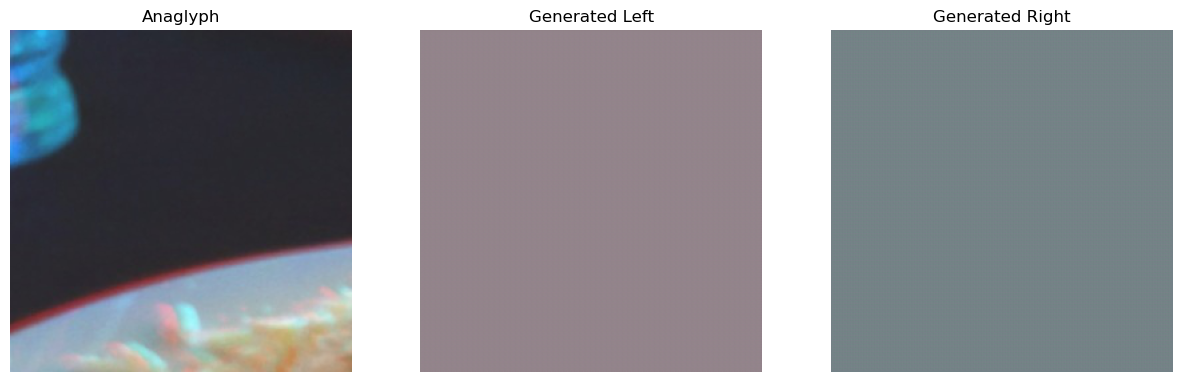

Saved validation results for image 2 of epoch 1 at 20250120_184911


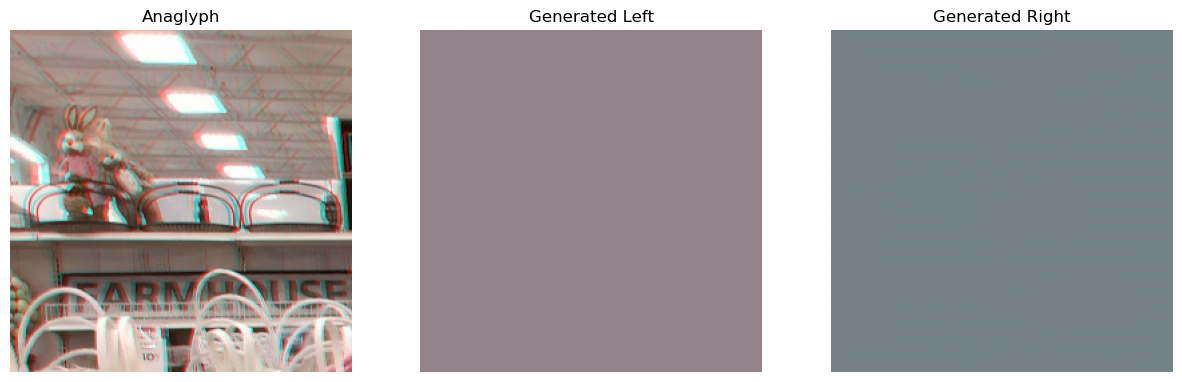

Saved validation results for image 3 of epoch 1 at 20250120_184913


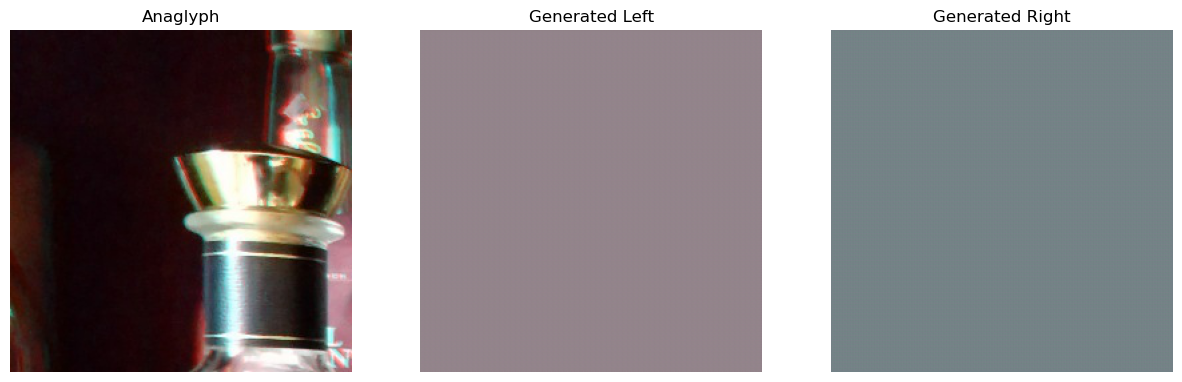

Epoch 2/2:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/2] - Discriminator Loss: 1.2505, Generator Loss: 3.0337
Saved model checkpoints for epoch 2 at 20250120_184921
Saved validation results for image 1 of epoch 2 at 20250120_184929


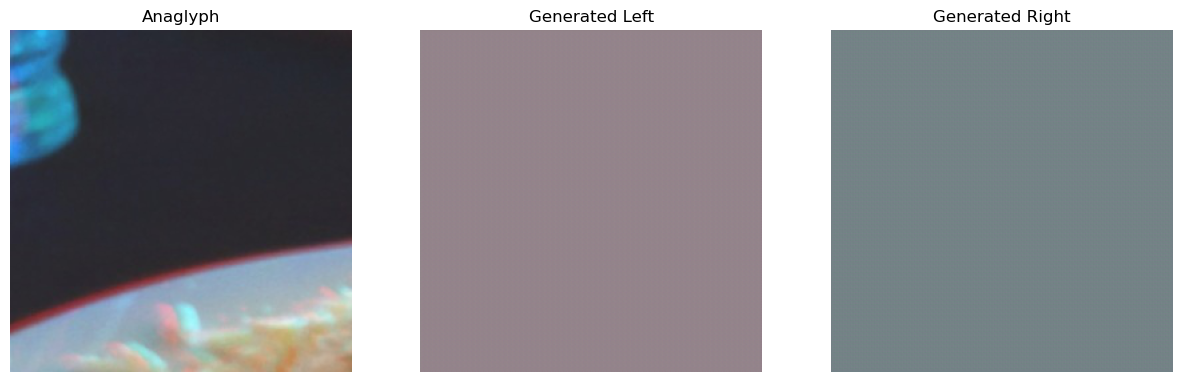

Saved validation results for image 2 of epoch 2 at 20250120_184931


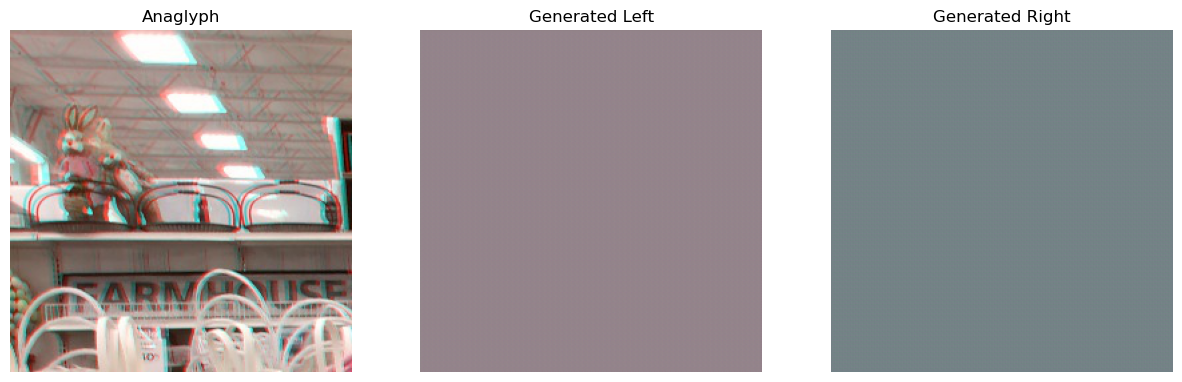

Saved validation results for image 3 of epoch 2 at 20250120_184933


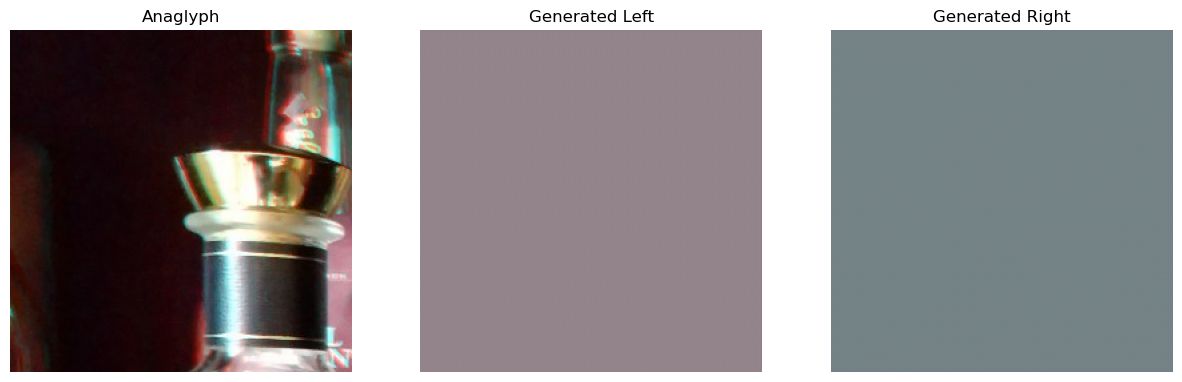

In [13]:
# Test run to see if everything is working

single_item_dl = make_dataloaders(path_anaglyph=c.TRAIN_ANAGLYPH_FILE, path_left=c.TRAIN_LEFT_FILE, path_right=c.TRAIN_RIGHT_FILE, files_limit=1)

train_gan(generator, discriminator, single_item_dl, 2, device, test_run=True)


In [ ]:
# Start the training
train_gan(generator, discriminator, train_dl, num_epochs, device)